# Introduction à 🤗 Diffusers

![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/en/imgs/diffusers_library.jpg)

Dans ce *notebook*, vous allez entraîner votre premier modèle de diffusion pour générer des images de mignons papillons 🦋. 
En cours de route, vous apprendrez les composants de base de la bibliothèque 🤗 *Diffusers*, qui fournira une bonne assise pour les applications plus avancées que nous couvrirons plus tard dans le cours.

## Ce que vous allez apprendre

Dans ce *notebook*, vous allez :

- Voir un puissant pipeline de modèles de diffusion personnalisé en action (avec des informations sur la façon de créer votre propre version).
- Créer votre propre mini-pipeline en :
	- Récapitulant les idées principales derrière les modèles de diffusion
    - Chargement de données à partir du Hub pour l'entraînement
    - Explorer comment ajouter du bruit à ces données à l'aide d'un planificateur
    - Créer et entraîner le modèle UNet
    - Rassembler les pièces du puzzle pour en faire un pipeline fonctionnel
- Éditer et exécuter un script pour initialiser des séries d'entraînement plus longues, qui gèrera
	- Entraînement multi-GPU via 🤗 *Accelerate*
	- Journalisation de l'expérience pour suivre les statistiques critiques
	- Téléchargement du modèle final sur le *Hub* d'*Hugging Face*  

❓ Si vous avez des questions, merci de les poster sur le canal `#diffusion-models-class` du [serveur Discord d'Hugging Face](https://huggingface.co/join/discord).

## Prérequis

Avant de vous plonger dans ce *notebook*, vous devez :

* 📖 Lire le matériel de l'Unité 1
* 🤗 Créer un compte Hugging Face. Si vous ne l'avez pas encore fait, vous pouvez le faire ici : https://huggingface.co/join

## Étape 1 : Configuration

Exécutez la cellule suivante pour installer la bibliothèque 🤗 *Diffusers* ainsi que quelques autres prérequis :

In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

Ensuite, rendez-vous sur https://huggingface.co/settings/tokens et créez un *tokens* d'accès avec autorisation d'écriture si vous n'en avez pas déjà un :

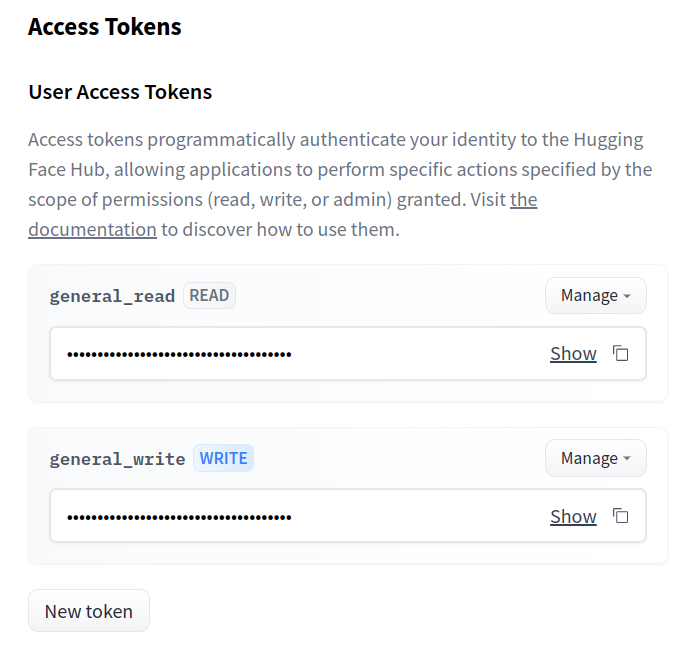

Vous pouvez vous connecter avec ce token en utilisant la ligne de commande (`huggingface-cli login`) ou en exécutant la cellule suivante :

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Vous devez ensuite installer Git-LFS pour télécharger les *checkpoints* de votre modèle :

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

Enfin, importons les bibliothèques que nous utiliserons et définissons quelques fonctions de confort que nous utiliserons plus tard dans le *notebook* :

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Étant donné un lot d'images x, faire une grille et convertir en PIL"""
    x = x * 0.5 + 0.5  # On va de (-1, 1) et revenons (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Étant donné une liste d'images PIL, les empiler en une ligne pour faciliter la visualisation."""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Les utilisateurs de Mac peuvent avoir besoin de device = 'mps' (non testé)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OK, nous sommes prêts !

## Dreambooth : un avant-goût de ce qui nous attend

Si vous avez un tant soit peu consulté les médias sociaux au cours des derniers mois, vous avez certainement entendu parler de *Stable Diffusion*. Il s'agit d'un puissant modèle de diffusion latent conditionné par le texte (ne vous inquiétez pas, nous allons apprendre ce que cela signifie). Mais il a un défaut : il ne sait pas à quoi vous ou moi ressemblons, à moins que nous soyons suffisamment célèbres pour que nos images soient répandues sur internet.

Dreambooth nous permet de créer notre propre variante de modèle avec une connaissance supplémentaire d'un visage, d'un objet ou d'un style spécifique. Le Corridor Crew a réalisé une excellente vidéo (en anglais) en utilisant cette technique pour raconter des histoires avec des personnages cohérents, ce qui est un excellent exemple de ce que cette technique peut faire :

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("W4Mcuh38wyM")

Voici un exemple d'une sortie d'un [modèle](https://huggingface.co/sd-dreambooth-library/mr-potato-head) entraîné sur 5 photos du jouet Monsieur Patate.

Tout d'abord, nous chargeons le pipeline. Ceci télécharge les poids du modèle depuis le Hub. Étant donné que plusieurs gigaoctets de données sont téléchargés pour une démonstration d'une ligne, vous pouvez sauter cette cellule et simplement admirer la sortie de l'exemple !

In [ ]:
from diffusers import StableDiffusionPipeline

# Consultez https://huggingface.co/sd-dreambooth-library pour découvrir de nombreux modèles provenant de la communauté
model_id = "sd-dreambooth-library/mr-potato-head"

# Chargement du pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

Une fois le chargement du pipeline terminé, nous pouvons générer des images avec :

In [ ]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

**Exercice** : essayez vous-même avec des prompts différents. Le *token* `sks` représente un identifiant unique pour le nouveau concept, que se passe-t-il si vous l'omettez ? Vous pouvez aussi expérimenter en changeant le nombre de pas d'échantillonnage (jusqu'où pouvez-vous descendre ?) et le paramètre `guidance_scale`, qui détermine jusqu'à quel point le modèle va essayer de correspondre au prompt.

Il se passe beaucoup de choses dans ce pipeline ! À la fin du cours, vous saurez comment tout cela fonctionne. Pour l'instant, voyons comment nous pouvons entraîner un modèle de diffusion à partir de zéro.

## MVP (Minimum Viable Pipeline)

L'API de base de 🤗 Diffusers est divisée en trois composants principaux :
- **Pipelines** : classes de haut niveau conçues pour générer rapidement des échantillons à partir de modèles de diffusion populaires entraînés de manière conviviale.
- **Models** : architectures populaires pour entraîner de nouveaux modèles de diffusion, par exemple [UNet](https://arxiv.org/abs/1505.04597).
- **Schedulers** : diverses techniques pour générer des images à partir du bruit pendant l'*inférence* ainsi que pour générer des images bruitées pour l'*entraînement*.

Les pipelines sont parfaits pour les utilisateurs finaux, mais si vous êtes ici pour ce cours, nous supposons que vous voulez savoir ce qui se passe sous le capot ! Dans le reste de ce *notebook*, nous allons donc construire notre propre pipeline capable de générer de petites images de papillons. Voici le résultat final en action :

In [ ]:
from diffusers import DDPMPipeline

# Chargement du pipeline de papillons
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Création de 8 images
images = butterfly_pipeline(batch_size=8).images

# Visualisation du résultat
make_grid(images)

Ce n'est peut-être pas aussi impressionnant que l'exemple de DreamBooth, mais nous entraînons notre modèle à partir de zéro avec ~0,0001% des données utilisées pour entraîner Stable Diffusion. En parlant d'entraînement, rappelez-vous que l'entraînement d'un modèle de diffusion ressemble à ceci :
- Chargement de quelques images à partir des données entraînées.
- Ajout de bruit, en différentes quantités.
- Introduction des versions bruitées des données d'entrée dans le modèle.
- Évaluation de la capacité du modèle à débruiter ces données d'entrée
- Utilisation de ces informations pour mettre à jour les poids du modèle, et répétition.

Nous allons explorer ces étapes une par une dans les prochaines parties jusqu'à ce que nous ayons une boucle d'entraînement complète, puis nous verrons comment échantillonner à partir du modèle entraîné et comment regrouper le tout dans un pipeline pour faciliter le partage. Commençons par les données.

## Etape 2 : Télécharger le jeu de données d'entraînement

Pour cet exemple, nous utilisons un jeu de données d'images provenant du *Hub* d'*Hugging Face*. Plus précisément, cette collection de [1000 images de papillons](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). Il s'agit d'un très petit jeu de données, c'est pourquoi nous avons aussi inclus des lignes en commentaires pour quelques options plus importantes. Si vous préférez utiliser votre propre collection d'images, vous pouvez également utiliser l'exemple de code commenté pour charger des images à partir d'un dossier.

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Ou charger des images à partir d'un dossier local
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# Nous entraînerons sur des images carrées de 32 pixels, mais vous pouvez aussi essayer des tailles plus grandes
image_size = 32
# Vous pouvez réduire la taille de votre batch si vous manquez de mémoire GPU
batch_size = 64

# Définition les augmentations de données
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Redimensionner
        transforms.RandomHorizontalFlip(),  # Retournement aléatoire
        transforms.ToTensor(),  # Convertir en tenseur (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Passage en (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Créer un chargeur de données à partir du jeu de données pour servir les images transformées en batchs
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Nous pouvons saisir un batch d'images et en visualiser quelques-unes comme suit :

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

Nous nous en tenons à un petit jeu de données avec des images de 32 pixels pour que les temps d'entraînement restent raisonnables dans ce *notebook*.

## Etape 3: Définir le planificateur

Notre plan d'entraînement consiste à prendre ces images d'entrée et à leur ajouter du bruit, puis à transmettre les images bruitées au modèle. Lors de l'inférence, nous utiliserons les prédictions du modèle pour supprimer le bruit de manière itérative. Dans *Diffusers*, ces deux processus sont gérés par le *scheduler* (planificateur).

Le planificateur de bruit détermine la quantité de bruit ajoutée à différents moments. Voici comment nous pourrions créer un planificateur en utilisant les paramètres par défaut pour l'entraînement et l'échantillonnage "DDPM" (d'après l'article [*Denoising Diffusion Probabalistic Models*](https://arxiv.org/abs/2006.11239)) :

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Le papier DDPM décrit un processus de corruption qui ajoute une petite quantité de bruit à chaque pas de temps. Étant donné $x_{t-1}$ pour un certain pas de temps, nous pouvons obtenir la version suivante (légèrement plus bruyante) $x_t$ avec :  

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br>

Nous prenons $x_{t-1}$, l'échelonnons de $\sqrt{1 - \beta_t}$ et ajoutons du bruit échelonné par $\beta_t$. Ce $\beta$ est défini pour chaque $t$ selon un certain planificateur et détermine la quantité de bruit ajoutée par pas de temps. Maintenant, nous ne voulons pas nécessairement faire cette opération 500 fois pour obtenir $x_{500}$, nous avons donc une autre formule pour obtenir $x_t$ pour n'importe quel t étant donné $x_0$ :

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

La notation mathématique fait toujours peur ! Heureusement, le planificateur s'en charge pour nous. Nous pouvons tracer $\sqrt{\bar{\alpha}_t}$ (appelé `sqrt_alpha_prod`) et $\sqrt{(1 - \bar{\alpha}_t)}$ (appelé `sqrt_one_minus_alpha_prod`) pour voir comment l'entrée ($x$) et le bruit sont mis à l'échelle et mélangés à travers différents pas de temps :

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**Exercice** : Vous pouvez explorer comment ce graphique change avec différents paramètres pour `beta_start`, `beta_end` et `beta_schedule` en remplaçant l'une des options commentées ci-dessous :

In [ ]:
## Exemple avec beaucoup de bruit ajouté :
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

## Le planificateur cosinus pouvant s'avérer meilleur pour les images de petite taille :
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Quel que soit le planificateur que vous avez choisi, nous pouvons maintenant l'utiliser pour ajouter du bruit en différentes quantités en utilisant la fonction `noise_scheduler.add_noise` comme suit :

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

Là encore, étudiez l'effet de l'utilisation de différents planificateurs et paramètres de bruit. Cette [vidéo](https://www.youtube.com/watch?v=fbLgFrlTnGU) (en anglais) explique en détail certains des calculs ci-dessus et constitue une excellente introduction à certains de ces concepts.

## Etape 4 : Définir le modèle

Nous en arrivons maintenant à l'élément central : le modèle lui-même.

La plupart des modèles de diffusion utilisent des architectures qui sont des variantes d'un [U-net](https://arxiv.org/abs/1505.04597) et c'est ce que nous utiliserons ici.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

En bref :
- l'image en entrée du modèle passe par plusieurs blocs de couches ResNet, chacun divisant la taille de l'image par 2
- puis elle passe à travers le même nombre de blocs qui la suréchantillonnent.
- il y a des *skip connections* qui relient les caractéristiques sur le chemin du sous-échantillonnage aux couches correspondantes dans le chemin du suréchantillonnage.

L'une des principales caractéristiques de ce modèle est qu'il prédit des images de la même taille que l'entrée, ce qui est exactement ce dont nous avons besoin ici.

*Diffusers* nous fournit une classe `UNet2DModel` pratique qui crée l'architecture désirée dans PyTorch.

Créons un U-net pour la taille d'image désirée. Notez que les `down_block_types` correspondent aux blocs de sous-échantillonnage (en vert sur le diagramme ci-dessus), et que les `up_block_types` sont les blocs de suréchantillonnage (en rouge sur le diagramme) :

In [ ]:
from diffusers import UNet2DModel

# Création d'un modèle
model = UNet2DModel(
    sample_size=image_size,  # la résolution de l'image cible
    in_channels=3,  # le nombre de canaux d'entrée, 3 pour les images RVB
    out_channels=3,  # le nombre de canaux de sortie
    layers_per_block=2,  # le nombre de couches ResNet à utiliser par bloc UNet
    block_out_channels=(64, 128, 128, 256),  # Plus de canaux -> plus de paramètres
    down_block_types=(
        "DownBlock2D",  # un bloc de sous-échantillonnage ResNet standard
        "DownBlock2D",
        "AttnDownBlock2D",  # un bloc de sous-échantillonnage ResNet avec auto-attention spatiale
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # un bloc de suréchantillonnage ResNet avec auto-attention spatiale
        "UpBlock2D",
        "UpBlock2D",  # un bloc de suréchantillonnage ResNet standard
    ),
)
model.to(device)

Lorsque vous traitez des données d'entrée en haute résolution, vous pouvez utiliser davantage de blocs descendants et ascendants, et ne conserver les couches d'attention que pour les couches de résolution les plus basses (inférieures) afin de réduire l'utilisation de la mémoire. Nous verrons plus tard comment vous pouvez expérimenter pour trouver les meilleurs paramètres pour votre cas d'utilisation.

Nous pouvons vérifier que le passage d'un batch de données et de pas de temps aléatoires produit une sortie de même forme que les données d'entrée :

In [ ]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

Dans la section suivante, nous verrons comment entraîner ce modèle.

## Etape 5 : Créer une boucle d'entraînement

Il est temps d'entraîner ! Voici une boucle d'optimisation typique dans PyTorch, où nous parcourons les données batch par batch et mettons à jour les paramètres de notre modèle à chaque étape à l'aide d'un optimiseur, ici, l'optimiseur AdamW avec un taux d'apprentissage de 0,0004.

Pour chaque batch de données, nous
- échantillonnons des pas de temps aléatoires
- bruitons les données en conséquence
- transmettons les données bruitées au modèle
- comparons les prédictions du modèle avec la cible (c'est-à-dire le bruit dans ce cas) en utilisant l'erreur quadratique moyenne comme fonction de perte
- mettons à jour les paramètres du modèle via `loss.backward()` et `optimizer.step()`.

Au cours de ce processus, nous enregistrons aussi les pertes au fil du temps pour un tracé ultérieur.

NB : ce code prend près de 10 minutes à exécuter. N'hésitez pas à sauter ces deux cellules et à utiliser le modèle pré-entraîné si vous êtes pressé. Vous pouvez également étudier comment la réduction du nombre de canaux dans chaque couche via la définition du modèle ci-dessus peut accélérer les choses.

L'[exemple officiel d'entraînement](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) de *Diffusers* entraîne un modèle plus grand sur ce jeu de données à une résolution plus élevée, et constitue une bonne référence pour ce à quoi ressemble une boucle d'entraînement moins minimale :

In [ ]:
# Définir le planificateur de bruit
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Boucle d'entraînement
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Exemple de bruit à ajouter aux images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Échantillonner un pas de temps aléatoire pour chaque image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Ajouter du bruit aux images propres en fonction de l'ampleur du bruit à chaque étape
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Obtenir la prédiction du modèle
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculer la perte
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Mise à jour des paramètres du modèle à l'aide de l'optimiseur
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

En traçant la perte, nous constatons que le modèle s'améliore rapidement dans un premier temps, puis continue à s'améliorer à un rythme plus lent (ce qui est plus évident si nous utilisons une échelle logarithmique, comme indiqué à droite) :

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

Au lieu d'exécuter le code d'entraînement ci-dessus, vous pouvez utiliser le modèle du pipeline comme suit :

In [ ]:
## Décommenter pour charger le modèle que j'ai entraîné plus tôt à la place :
# model = butterfly_pipeline.unet

## Etape 6 : Générer des images

Comment obtenir des images avec ce modèle ?

### Option 1 : Création d'un pipeline

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
pipeline_output = image_pipe()
pipeline_output.images[0]

Nous pouvons enregistrer un pipeline dans un dossier local comme suit :

In [ ]:
image_pipe.save_pretrained("my_pipeline")

Inspection du contenu du dossier :

In [ ]:
!ls my_pipeline/

Les sous-dossiers `scheduler` et `unet` contiennent tout ce qui est nécessaire pour recréer ces composants. Par exemple, dans le dossier `unet` vous trouverez les poids du modèle (`diffusion_pytorch_model.bin`) ainsi qu'un fichier de configuration qui spécifie l'architecture UNet.

In [ ]:
!ls my_pipeline/unet/

Ensemble, ces fichiers contiennent tout ce qui est nécessaire pour recréer le pipeline. Vous pouvez les télécharger manuellement sur le *Hub* pour partager le pipeline avec d'autres personnes, ou consulter le code pour le faire via l'API dans la section suivante.

### Option 2: Writing a Sampling Loop

Si vous inspectez la méthode `forward` du pipeline, vous pourrez voir ce qui se passe lorsque nous lançons `image_pipe()` :

In [ ]:
# ??image_pipe.forward

Nous commençons par un bruit aléatoire et parcourons les pas de temps de l'ordonnanceur du plus bruyant au moins bruyant, en supprimant une petite quantité de bruit à chaque étape sur la base de la prédiction du modèle :

In [ ]:
# Point de départ aléatoire (8 images aléatoires) :
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Obtenir le modèle de prédiction
    with torch.no_grad():
        residual = model(sample, t).sample

    # Mise à jour de l'échantillon avec le pas
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

La fonction `noise_scheduler.step()` effectue les calculs nécessaires pour mettre à jour `sample` de manière appropriée. Il existe un certain nombre de méthodes d'échantillonnage. Dans l'unité suivante, nous verrons comment nous pouvons échanger un échantillonneur différent pour accélérer la génération d'images avec des modèles existants, et nous parlerons plus en détail de la théorie derrière l'échantillonnage des modèles de diffusion.

## Etape 7 : Pousser votre modèle vers le *Hub*

Dans l'exemple ci-dessus, nous avons enregistré notre pipeline dans un dossier local. Pour pousser notre modèle vers le *Hub*, nous aurons besoin d'un dépôt de modèles dans lequel nous pourrons pousser nos fichiers. Nous déterminerons le nom du dépôt à partir de l'ID du modèle que nous voulons donner à notre modèle (n'hésitez pas à remplacer le nom du modèle par votre propre choix ; il doit juste contenir votre nom d'utilisateur, ce que fait la fonction `get_full_repo_name()`) :

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

Ensuite, créer un dépôt de modèle sur le 🤗 *Hub* et pousser notre modèle :

In [ ]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

La dernière chose à faire est de créer une belle carte modèle afin que notre générateur de papillons puisse être facilement trouvé sur le 🤗 *Hub* (n'hésitez pas à développer et à modifier la description !) :

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

Maintenant que le modèle est sur le *Hub*, vous pouvez le télécharger de n'importe où en utilisant la méthode `from_pretrained()` de `DDPMPipeline` comme suit :

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

Bien, ça marche !

## Passer à l'échelle supérieure avec 🤗 *Accelerate*
Ce *notebook* a été conçu à des fins d'apprentissage, et en tant que tel, nous avons essayé de garder le code aussi minimal et propre que possible. Pour cette raison, nous avons omis certaines choses que vous pourriez souhaiter si vous deviez entraîner un modèle plus grand sur beaucoup plus de données, comme le support multi-GPU, la trace de la progression et des images d'exemple, la sauvegarde du gradient pour supporter des tailles de batch plus importantes, le téléchargement automatique des modèles et ainsi de suite. Heureusement, la plupart de ces fonctionnalités sont disponibles dans l'exemple de script d'entraînement [ici](https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py).

Vous pouvez télécharger le fichier comme suit :

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

Ouvrez le fichier et vous verrez où le modèle est défini et quels sont les paramètres disponibles. Nous exécutons le script à l'aide de la commande suivante :

In [ ]:
# Donnons un nom à notre nouveau modèle pour le Hub
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

In [ ]:
!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

Comme précédemment, poussons le modèle vers le *Hub* et créons une belle carte de modèle (et n'hésitez pas à l'éditer comme vous le souhaitez !):

In [ ]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

Environ 45 minutes plus tard, voici le résultat :

In [ ]:
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)

**Exercice** : essayez de trouver des paramètres d'entraînement/de modèle qui donnent de bons résultats en un minimum de temps, et partagez vos résultats avec la communauté. Fouillez dans le script pour voir si vous pouvez comprendre le code, et demandez des éclaircissements sur tout ce qui vous semble confus.

# Pistes d'approfondissement

Nous espérons vous avoir donné un avant-goût de ce que vous pouvez faire avec la bibliothèque 🤗 *Diffusers* ! Voici quelques pistes possibles pour la suite :
- Essayez d'entraîner un modèle de diffusion inconditionnel sur un nouveau jeu de données. Points bonus si vous en [créez un vous-même](https://huggingface.co/docs/datasets/image_dataset). Vous pouvez trouver d'excellents jeux de données d'images pour cette tâche dans l'[organisation HugGan](https://huggingface.co/huggan) sur le *Hub*. Assurez-vous simplement de les sous-échantillonner si vous ne voulez pas attendre très longtemps pour que le modèle s'entraîne !
- Essayez DreamBooth pour créer votre propre pipeline de Stable Diffusion personnalisé en utilisant ce [Space]((https://huggingface.co/spaces/multimodalart/dreambooth-training) ou ce [*notebook*](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb).
- Modifiez le script d'entraînement pour explorer différents hyperparamètres UNet (nombre de couches, canaux, etc.), différents schémas de bruit, etc.
- Consultez le *notebook* [*Implémentation à partir de 0*](https://github.com/huggingface/diffusion-models-class/blob/main/fr/unit1/diffusion_models_from_scratch.ipynb) pour une approche différente des idées fondamentales que nous avons abordées dans cette unité.